In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm

In [2]:
# Starting dataset
df = pd.read_csv('datasets/customer_dataframe.csv', sep='\t', index_col=0)
df

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,SEShoppingDays,MaxOrderMonth,MaxOrderDay,MeanTimeGap
CustomerID,,,,,,,,,,,,,,,,
17850,1702,21,48.629,5317.89,6.36,107.25,151.940,31,3.960,34,4.137,3.186,1.000,Dec,Thu,2.088
13047,1355,105,84.688,3089.10,6.64,68.00,193.069,35,3.926,9,5.421,3.875,2.322,Aug,Wed,21.800
12583,4978,114,292.824,6629.34,6.80,132.80,389.961,50,2.140,15,5.804,4.087,2.585,Sep,Fri,23.188
13748,439,24,87.800,948.25,9.36,204.00,189.650,0,3.996,5,4.080,2.322,1.585,Apr,Mon,69.500
15100,58,1,9.667,635.10,175.20,350.40,105.850,22,10.950,3,2.252,2.252,2.000,Dec,Wed,8.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13436,76,12,76.000,196.89,10.20,25.50,196.890,0,5.830,1,3.418,0.000,0.000,Dec,Thu,0.000
15520,314,18,314.000,343.50,9.48,34.68,343.500,0,1.724,1,2.997,0.000,0.000,Dec,Thu,0.000
13298,96,2,96.000,360.00,90.00,270.00,360.000,0,3.750,1,1.000,0.000,0.000,Dec,Thu,0.000


In [3]:
selected_features = ['TProd','MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']
df_aux = df[selected_features]
df_aux.head()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
CustomerID,,,,
17850,1702,48.629,151.940,3.960
13047,1355,84.688,193.069,3.926
12583,4978,292.824,389.961,2.140
13748,439,87.800,189.650,3.996
15100,58,9.667,105.850,10.950


In [4]:
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_aux.to_numpy())

In [5]:
# defining some functions that will help in handling results       
def get_clusters(clusters, ignore=[]):
    cust_clust = {}
    for i in range(len(clusters)):
        for customer in clusters[i]:
            cust_clust[customer] = i
    clustering = []
    for cust in sorted(cust_clust):
        clustering.append(cust_clust[cust])
    return clustering

In [6]:
# initialize centroids
initial_centers = kmeans_plusplus_initializer(df_norm, 4, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(df_norm, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

Text(0.5, 0, 'MeanSaleOrder')

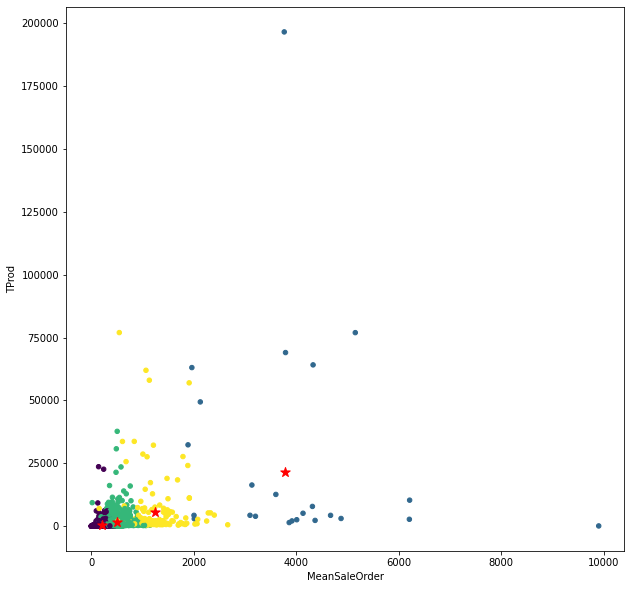

In [7]:
cl = get_clusters(clusters)
center_norm = scaler.inverse_transform(centers)
fig, axs = plt.subplots(1,1,figsize=(10,10))
label_s = 10
col1, i1 = df_aux['MeanSaleOrder'], 2
col2, i2 = df_aux['TProd'], 0
axs.scatter(col1, col2, c=cl, s=20)
axs.scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs.tick_params(axis='both', which='major', labelsize=label_s)
axs.set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs.set_xlabel(df_aux.columns[i1], fontsize=label_s)

In [8]:
elem_per_clust = {}
for i in range(0,4):
    print('Len of clust',i,'is',len(clusters[i]))
    elem_per_clust[i] = len(clusters[i])
    
counter = 0
elem_per_clust = {k: v for k, v in sorted(elem_per_clust.items(), key=lambda item: item[1], reverse=True)}
for i in elem_per_clust.keys():
    elem_per_clust[i] = ['Low_Spend', 'Med_Spend', 'High_Spend','High_Spend'][counter]
    counter +=1
elem_per_clust

Len of clust 0 is 3084
Len of clust 1 is 24
Len of clust 2 is 1088
Len of clust 3 is 137


{0: 'Low_Spend', 2: 'Med_Spend', 3: 'High_Spend', 1: 'High_Spend'}

In [9]:
label_col = []

for i in range(0, len(df)):
    for j in range(0, len(clusters)):
        if i in clusters[j]:
            label_col.append(elem_per_clust[j])
            
df['Label'] = label_col
df = df.round(3)

for i in ['Low_Spend', 'Med_Spend', 'High_Spend']:
    print(i, len(df[df['Label'] == i]))
    
path = 'datasets/clustered_fuzzy_dataframe.csv'
df.to_csv(path, sep='\t')
print(f"\nClustered fuzzy dataframe saved to '{path}'")

Low_Spend 3084
Med_Spend 1088
High_Spend 161

Clustered fuzzy dataframe saved to 'datasets/clustered_fuzzy_dataframe.csv'
